In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from tqdm import tqdm

import sys 
sys.path.append("..")

from src.utils import ratemap_collage, spatial_correlation
plt.style.use("../figures/project_style.mplstyle")

#### Feedforward network

In [2]:
model = torch.load("../models/256_ff_context_0.pt")
model.lam, model.scale, model.beta

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_26573/256720405.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("../models/256_ff_context_0

(0.1, 0.25, 0.5)

In [3]:
# Evaluate on 2x2 grid
res = 32
x = np.linspace(-1, 1, res)
y = x.copy()
xx, yy = np.meshgrid(x, y)

In [4]:
model.lam

0.1

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_26573/2163100745.py:15: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0, wspace=0.1)


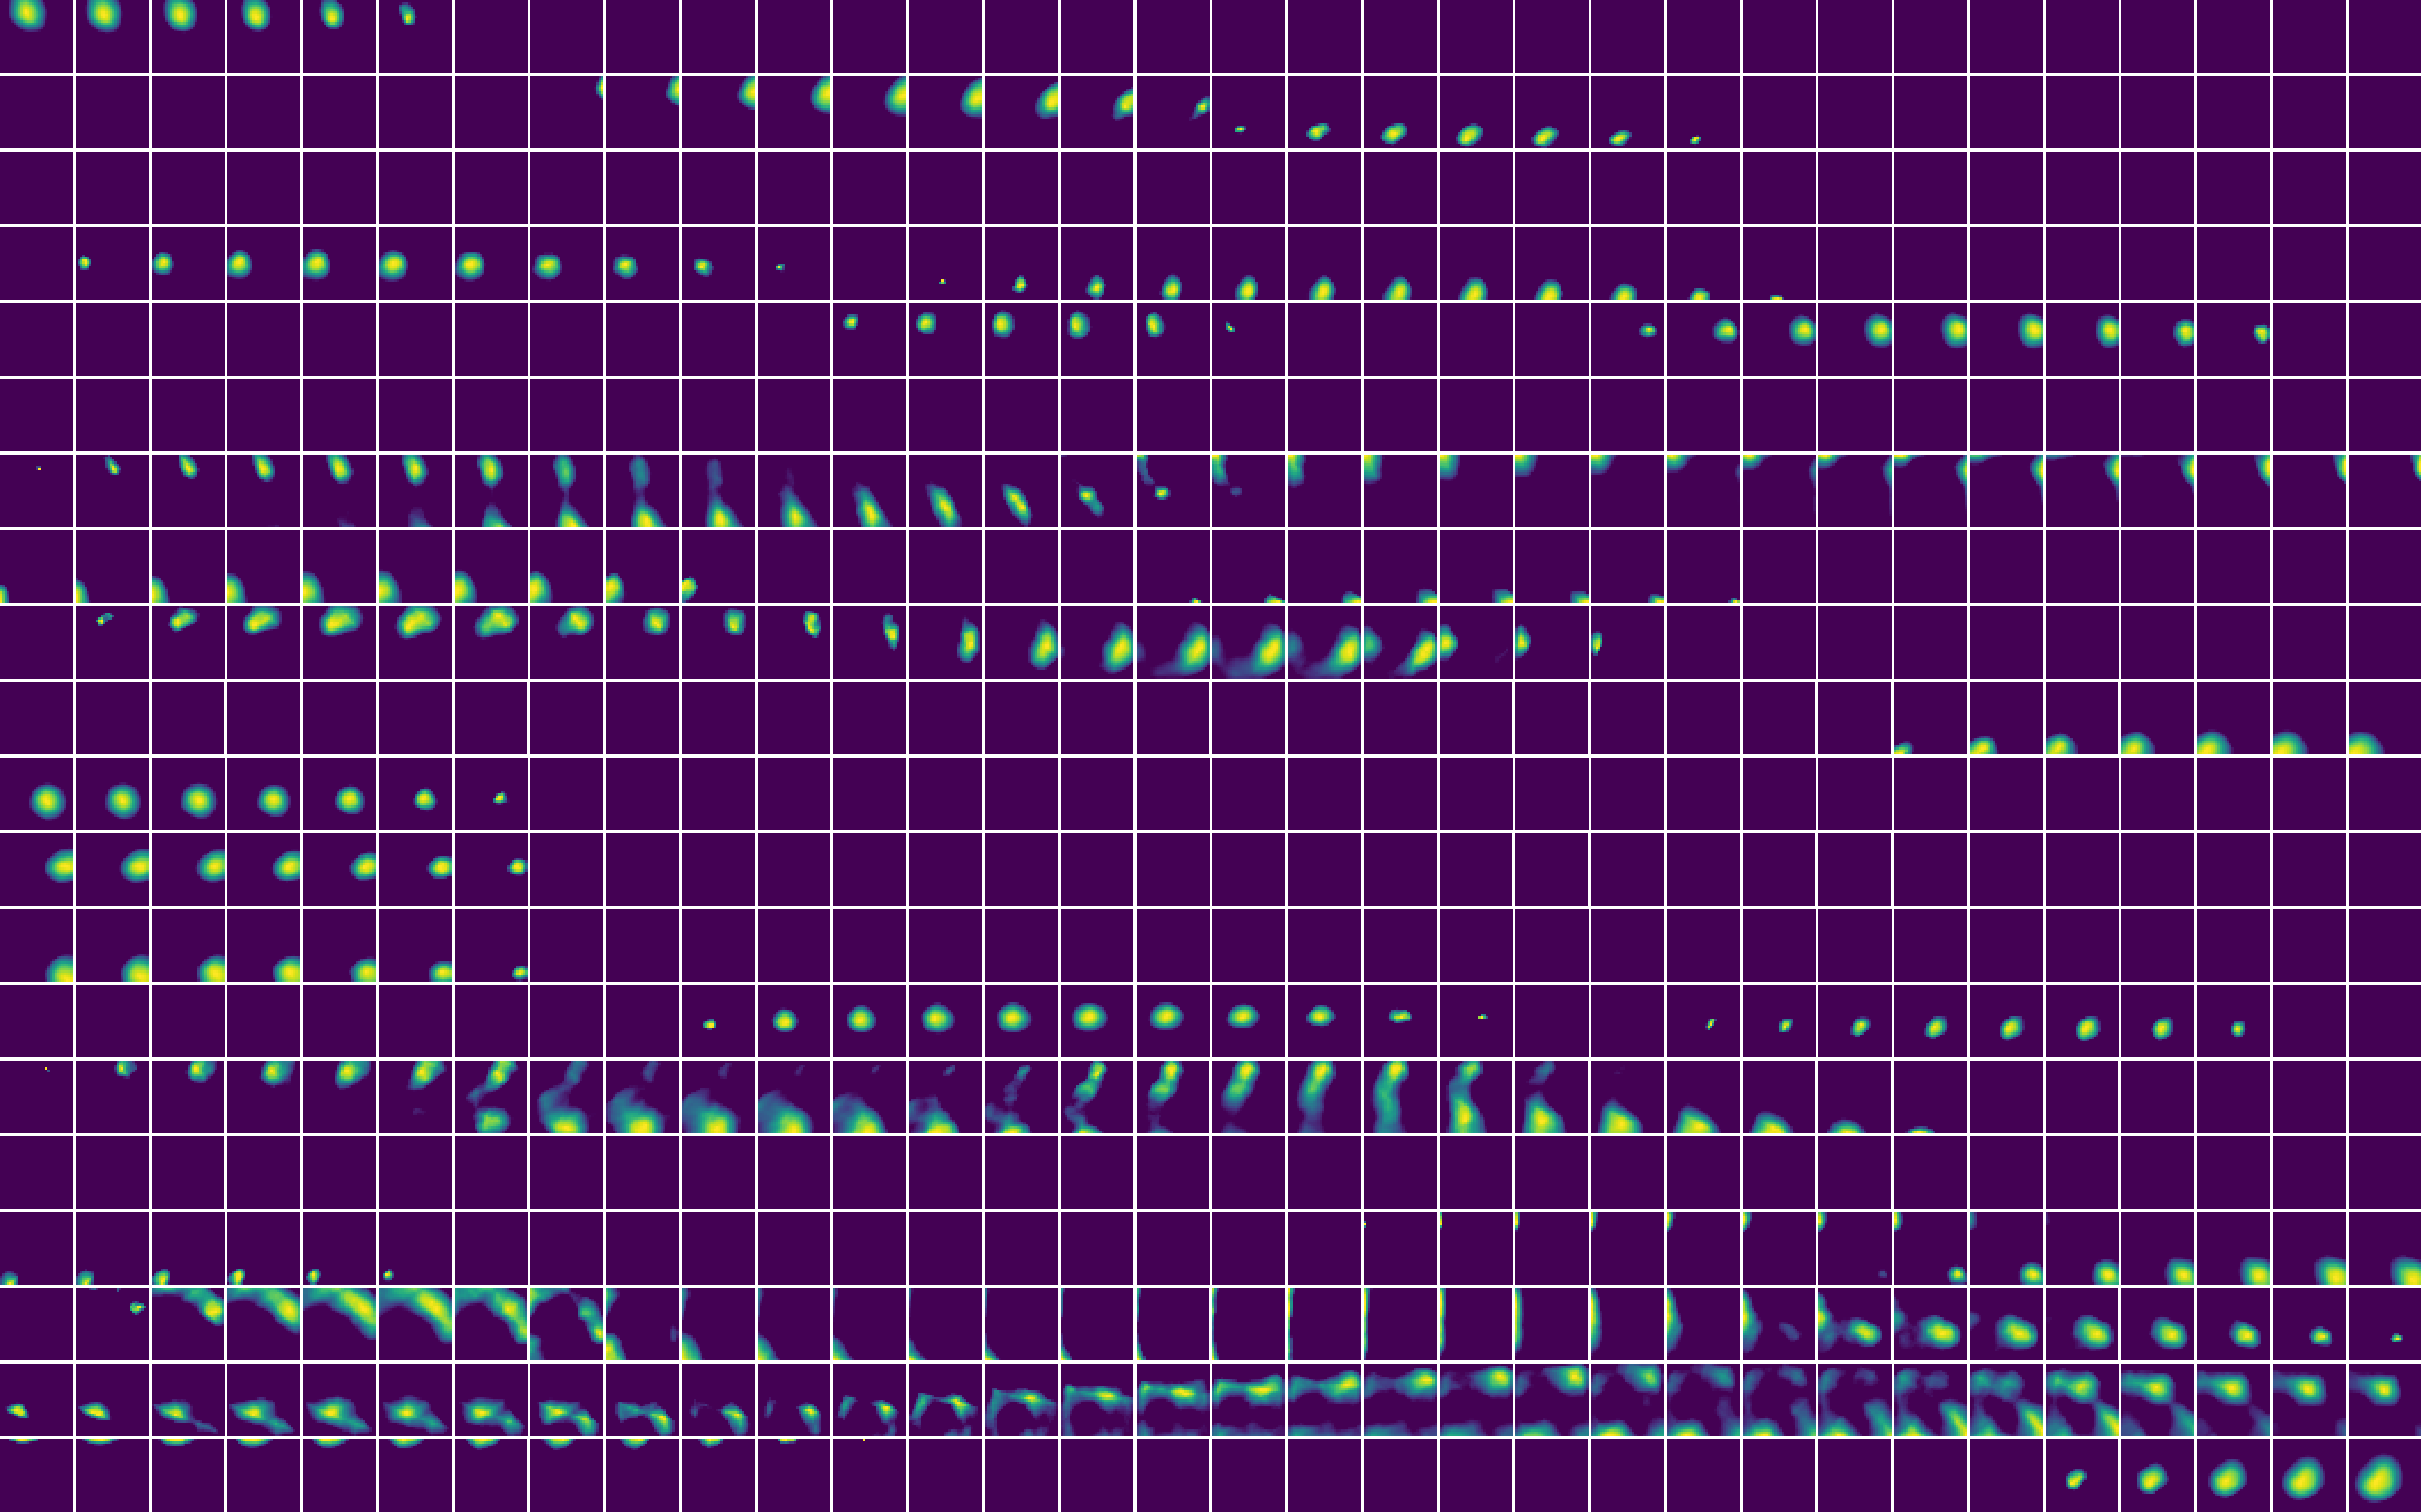

In [5]:
n = 20 # number of units to visualize
nc = 32 # number of contexts
contexts = np.linspace(-2, 2, nc)
fig, ax = plt.subplots(n, nc, figsize = (nc, n))

corrs = []

for i, c in enumerate(contexts):
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), c*torch.ones(res**2)], axis=-1), dtype=torch.float32)
    corr, p = model(u)
    p = p.detach().numpy()
    for j in range(n):
        ax[j,i].imshow(p[...,j].reshape(res,res))
        ax[j,i].axis("off")
plt.subplots_adjust(hspace=0, wspace=0.1)

In [6]:
corrs = []

for i in range(nc):
    ua = torch.tensor(np.stack([xx.ravel(), yy.ravel(), contexts[i]*torch.ones(res**2)], axis=-1), dtype=torch.float32)
    _, pa = model(ua)
    pa = pa.detach().numpy()
    current = []
    for j in range(nc):
        ub = torch.tensor(np.stack([xx.ravel(), yy.ravel(), contexts[j]*torch.ones(res**2)], axis=-1), dtype=torch.float32)
        _, pb = model(ub)
        pb = pb.detach().numpy()
        current.append(spatial_correlation(pa.T, pb.T))
    corrs.append(current)

In [7]:
# fig, ax = plt.subplots(nc, nc, figsize = (20,20))
median_corrs = np.zeros((nc, nc))
counts = np.zeros((nc, nc))

for i in range(nc):
    for j in range(nc):
        # ax[i,j].hist(corrs[i][j], bins = 32)
        median_corrs[i,j] = np.median(corrs[i][j])
        counts[i,j] = len(corrs[i][j])

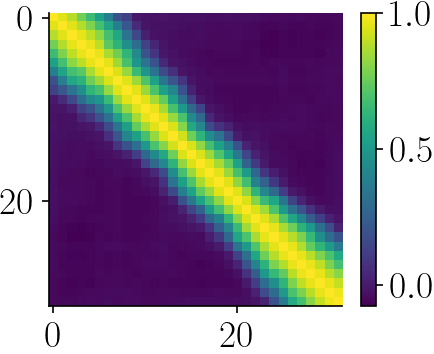

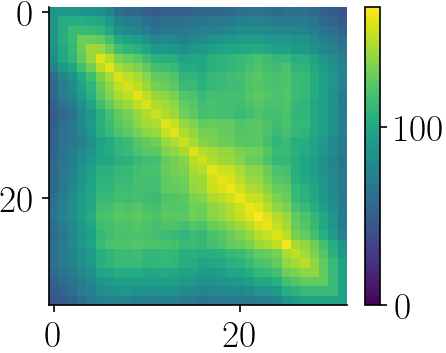

In [8]:
plt.imshow(median_corrs)
plt.colorbar()
plt.show()
plt.imshow(counts, vmin = 0)
plt.colorbar()

Text(0, 0.5, 'Count')

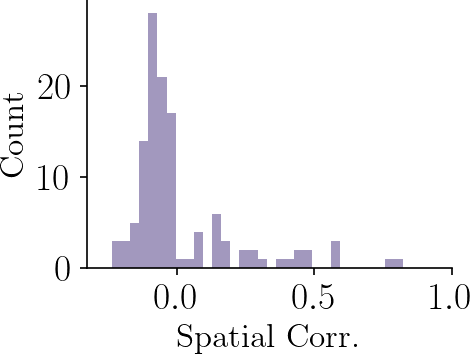

In [13]:
plt.hist(corrs[9][32-9], bins = 32, alpha = 0.5)
plt.xlim(np.amin(corrs[9][32-2]), 1)
plt.xlabel("Spatial Corr.")
plt.ylabel("Count")